In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/muchmoredata/MuchMoreData.csv


Ce dataset se compose d’abstracts de publications scientifiques médicales, qui traitent de différents domaines: Cardiologie, Ophtalmologie etc. On a donc un problème de classification multiclasses (assigne une seule des classes possibles à un document). La catégorie à laquelle appartient un document correspond à la première partie de son nom.

A partir de ce dataset, nous allo

*    

Proposer une analyse exploratoire des éon
*    ées
Présenter et commenter quelques visualisations et métriques pertine*    ntes
Comparer les performances de deux approches pour la classification des doc :  
1.   SVM l vs e
2.   Naiv*    e Bayes
Proposer une exploration interactive des données et résultats

In [2]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=dbc2f1a5209bd29edfeb61613b9d66dd5d4c165742e4e12b399ff6642ad0d41e
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [3]:
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
#from plotly import tools
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go

#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

import swifter
from sklearn.decomposition import PCA

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Analyse exploratoire des données

## Nombre total de documents

In [4]:
df = pd.read_csv("/kaggle/input/muchmoredata/MuchMoreData.csv")
df.shape[0]

7823

## Répartition des classes (nombre de documents par catégorie).

In [5]:
df['clean_category'] = df['category'].swifter.apply(lambda x: x.split('.')[0])
print(df.shape)
df.head()

Pandas Apply:   0%|          | 0/7823 [00:00<?, ?it/s]

(7823, 4)


,Unnamed: 0,category,content,clean_category
0,0,Arthroskopie.00130003.eng.abstr,The posterior cruciate ligament (PCL) is the s...,Arthroskopie
1,1,Arthroskopie.00130011.eng.abstr,An investigation of 122 knee joints was perfor...,Arthroskopie
2,2,Arthroskopie.00130017.eng.abstr,This article discusses the surgical treatment ...,Arthroskopie
3,3,Arthroskopie.00130030.eng.abstr,The treatment of acute posterior instabilities...,Arthroskopie
4,4,Arthroskopie.00130035.eng.abstr,"Since 1989, 99 people presenting with posterio...",Arthroskopie


In [6]:
print(len(df['clean_category'].value_counts()))
df['clean_category'].value_counts()

39


clean_category
DerHautarzt                        693
DerChirurg                         684
DerAnaesthesist                    539
DerNervenarzt                      493
DerRadiologe                       477
ZfuerKardiologie                   434
DerUnfallchirurg                   403
DerOpthalmologe                    399
DerOrthopaede                      356
MonatsschriftKinderheilkunde       355
HNO                                312
DerPathologe                       294
IntensiveMedizin                   242
MundKieferGesichtschirurgie        231
DerUrologeA                        224
ZfuerRheumatologie                 153
DerSchmerz                         140
ZfuerGerontologie+Geriatrie        137
DerGynaekologe                     133
Psychotherapeut                    122
Gefaesschirurgie                   106
Rechtsmedizin                      101
Arthroskopie                        95
ZfuerHerzThoraxGefaesschirurgie     93
Herzschrittmachertherapie           77
Bundesgesu

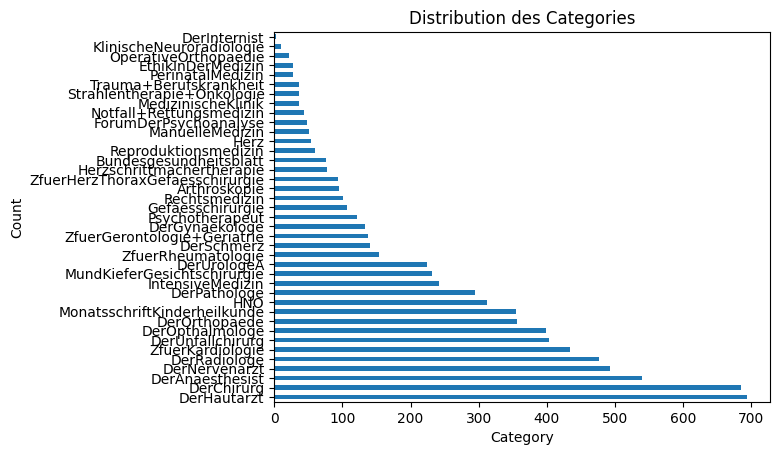

In [7]:
import matplotlib.pyplot as plt

df['clean_category'].value_counts().plot(kind='barh')
plt.ylabel('Count')
plt.xlabel('Category')
_ = plt.title('Distribution des Categories')

## Distribution des langues

In [8]:
df['lang'] = df['category'].swifter.apply(lambda x: x.split('.')[2])
df.head()

Pandas Apply:   0%|          | 0/7823 [00:00<?, ?it/s]

,Unnamed: 0,category,content,clean_category,lang
0,0,Arthroskopie.00130003.eng.abstr,The posterior cruciate ligament (PCL) is the s...,Arthroskopie,eng
1,1,Arthroskopie.00130011.eng.abstr,An investigation of 122 knee joints was perfor...,Arthroskopie,eng
2,2,Arthroskopie.00130017.eng.abstr,This article discusses the surgical treatment ...,Arthroskopie,eng
3,3,Arthroskopie.00130030.eng.abstr,The treatment of acute posterior instabilities...,Arthroskopie,eng
4,4,Arthroskopie.00130035.eng.abstr,"Since 1989, 99 people presenting with posterio...",Arthroskopie,eng


In [9]:
print(len(df['lang'].value_counts()))
df['lang'].value_counts()

1


lang
eng    7823
Name: count, dtype: int64

## Longueur moyenne des abstracts

In [10]:
def cal_len(data):
    return len(data)

df['content_length']= df['content'].str.split().apply(lambda z:cal_len(z))
df.head()

,Unnamed: 0,category,content,clean_category,lang,content_length
0,0,Arthroskopie.00130003.eng.abstr,The posterior cruciate ligament (PCL) is the s...,Arthroskopie,eng,343
1,1,Arthroskopie.00130011.eng.abstr,An investigation of 122 knee joints was perfor...,Arthroskopie,eng,138
2,2,Arthroskopie.00130017.eng.abstr,This article discusses the surgical treatment ...,Arthroskopie,eng,209
3,3,Arthroskopie.00130030.eng.abstr,The treatment of acute posterior instabilities...,Arthroskopie,eng,56
4,4,Arthroskopie.00130035.eng.abstr,"Since 1989, 99 people presenting with posterio...",Arthroskopie,eng,165


In [11]:
df['content_length'].value_counts()

content_length
96     56
87     54
97     52
61     51
104    50
       ..
525     1
485     1
474     1
571     1
344     1
Name: count, Length: 478, dtype: int64

# Quelques visualisations et métriques pertinentes

# Comparaisons des performances de SVM linéaire et Naive Bayes

# Exploration interactive des données et résultats

# Conclusions